In [141]:
# This reload library is just used for developing the REPUBLIC hOCR parser 
# and can be removed once this module is stable.
%reload_ext autoreload
%autoreload 2

# This is needed to add the repo dir to the path so jupyter
# can load the modules in the scripts directory from the notebooks
import os
import sys
repo_dir = os.path.split(os.getcwd())[0]
print(repo_dir)
if repo_dir not in sys.path:
    sys.path.append(repo_dir)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import csv
import os

data_dir = '../data/GoodReads'

books_10k_file = os.path.join(data_dir, 'goodreads_reviews-books_above_10k_lang_reviews.csv.gz')
reviewers_5k_file = os.path.join(data_dir, 'goodreads_reviews-reviewers_above_5k_reviews.csv.gz')
random_1M_file = os.path.join(data_dir, 'goodreads_reviews-random_sample_1M_non_zero.csv.gz')
author_file = os.path.join(data_dir, 'goodreads_book_authors.csv.gz') # author information
book_file = os.path.join(data_dir, 'goodreads_books.csv.gz') # basic book metadata


/Users/marijnkoolen/Code/Huygens/scale


In [142]:
review_df = pd.read_csv(random_1M_file, sep='\t', compression='gzip')
print('Number of reviews in dataset:', len(review_df))
review_df = review_df[review_df.review_length > 0]
print('Number of non-zero-length reviews in dataset:', len(review_df))


1007600


In [143]:
import math

review_df['log_length'] = review_df.review_length.apply(lambda x: int(math.log(x)*4)/4)
review_df['length_bin'] = review_df.log_length.apply(math.exp)


longest review: 20111
mean review length: 1017.6698168086382
median review length: 338.0


<AxesSubplot:>

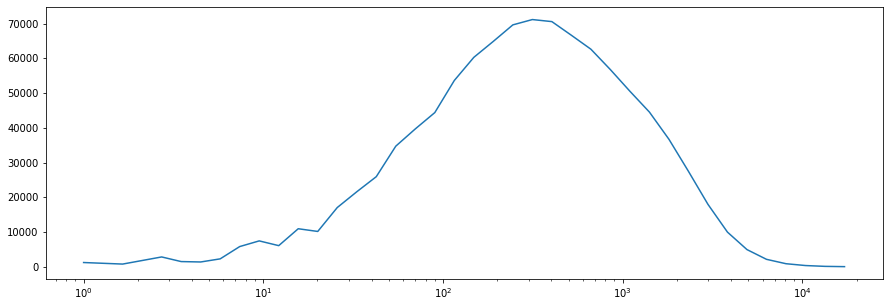

In [144]:

print('longest review:', review_df.review_length.max())
print('mean review length:', review_df.review_length.std())
print('median review length:', np.median(review_df.review_length))

review_df.length_bin.value_counts().sort_index().plot(logx=True)

In [145]:
from dateutil.parser import parse, tz

def parse_date(date_str):
    try:
        return parse(date_str).astimezone(utc)
    except TypeError:
        return None

utc = tz.gettz('UTC')

review_df['date_added'] = review_df.date_added.apply(parse_date)
review_df['date_updated'] = review_df.date_updated.apply(parse_date)
review_df['read_at'] = review_df.read_at.apply(parse_date)
review_df['started_at'] = review_df.started_at.apply(parse_date)





In [152]:
review_df.columns

Index(['Unnamed: 0', 'user_id', 'book_id', 'review_id', 'rating', 'date_added',
       'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments',
       'review_length', 'review_text', 'log_length', 'length_bin', 'author_id',
       'work_id', 'title', 'author_name', 'children', 'comics, graphic',
       'fantasy, paranormal', 'fiction',
       'history, historical fiction, biography', 'mystery, thriller, crime',
       'non-fiction', 'poetry', 'romance', 'young-adult', 'author_freq',
       'book_freq'],
      dtype='object')

In [147]:
# get a list of book ids that are in the review dataset
review_book_ids = set(review_df.book_id.unique())
print('unique book ids:', len(review_book_ids))

# load basic book metadata (only book and author id and book title)
bookmeta_df = pd.read_csv(book_file, sep='\t', compression='gzip', usecols=['book_id', 'work_id', 'author_id', 'title'])
print('book metadata read')

# filter the book metadata to only the book ids in the review dataset
bookmeta_df = bookmeta_df[bookmeta_df.book_id.isin(review_book_ids)]
print('book metadata filtered')

# load the author metadata to get author names 
author_df = pd.read_csv(author_file, sep='\t', compression='gzip', usecols=['author_id', 'name'])
author_df = author_df.rename(columns={'name': 'author_name'})
print('author metadata read')

# merge the book and author metadata into a single dataframe, 
# keeping only author names for books in the review dataset
metadata_df = pd.merge(bookmeta_df, author_df, how='left')
print('book and author metadata merged')

# merge the review dataset with the book metadata
review_df = pd.merge(review_df, metadata_df, on='book_id')
print('review and book metadata')


unique book ids: 404059
book metadata read
book metadata filtered
author metadata read
book and author metadata merged
review and book metadata


In [148]:
genre_file = os.path.join(data_dir, 'goodreads_book_genres_initial.csv.gz') # book genre information

#genre_df = pd.read_csv(genre_file, sep='\t', compression='gzip')
#genre_df = genre_df[genre_df.book_id.isin(review_book_ids)]
genre_df.genres.value_counts()

g = genre_df.groupby(['book_id', 'genres']).size()
print(len(g))
u_genres = g.unstack('genres').fillna(0)
u_genres = u_genres.reset_index()
print('number of books with genre information:', len(u_genres))

review_df = pd.merge(review_df, u_genres, on='book_id', how='left')

genres = list(u_genres.columns)[1:]
print(genres)

print('Number of reviews per genre:')
for genre in genres:
    print(f'{genre: <40}{len(review_df[review_df[genre] == 1]): >10}')

u_genres

1136144
number of books with genre information: 394888
['children', 'comics, graphic', 'fantasy, paranormal', 'fiction', 'history, historical fiction, biography', 'mystery, thriller, crime', 'non-fiction', 'poetry', 'romance', 'young-adult']
Number of reviews per genre:
children                                    127656
comics, graphic                              90404
fantasy, paranormal                         446156
fiction                                     918241
history, historical fiction, biography      354004
mystery, thriller, crime                    409302
non-fiction                                 199731
poetry                                       34223
romance                                     573330
young-adult                                 408106


genres,book_id,children,"comics, graphic","fantasy, paranormal",fiction,"history, historical fiction, biography","mystery, thriller, crime",non-fiction,poetry,romance,young-adult
0,1,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
1,2,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
2,3,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,4,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,5,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
394883,36488099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
394884,36494299,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
394885,36498328,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
394886,36508486,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [149]:
# add number of reviews per author for popular author selection
review_df['author_freq'] = review_df.groupby(['author_name'])['review_id'].transform('count')
review_df['book_freq'] = review_df.groupby(['book_id'])['review_id'].transform('count')
review_df

,Unnamed: 0,user_id,book_id,review_id,rating,date_added,date_updated,read_at,started_at,n_votes,...,"fantasy, paranormal",fiction,"history, historical fiction, biography","mystery, thriller, crime",non-fiction,poetry,romance,young-adult,author_freq,book_freq
0,0,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,2016-12-05 18:46:44+00:00,2017-03-22 18:37:04+00:00,None,None,1,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,47.0,39
1,8146,37d3651e895e35cd2818eb36d87c4367,16981,989d104e066141f8261d33d0ce64d7b5,4,2013-12-19 14:42:58+00:00,2013-12-26 17:16:02+00:00,2013-12-26 17:16:02+00:00,2013-12-19 08:00:00+00:00,0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,47.0,39
2,50004,a76cc6d83a5206d931a0064e2de99ae3,16981,61598fc0327e7ccf7099c1249128994f,5,2012-08-03 15:43:41+00:00,2012-11-24 23:36:41+00:00,2012-11-24 23:36:41+00:00,2012-11-20 08:00:00+00:00,0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,47.0,39
3,61923,2d712f5dba10518b7374de3cf946b993,16981,5924e2aaadfaf8fccb7dcaee289de15d,5,2012-08-21 02:32:11+00:00,2012-08-21 02:37:24+00:00,None,None,0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,47.0,39
4,62258,c5287ace96293b661475e65d40bf00d3,16981,95e2bd7a5349dc18832250aad0896533,4,2014-01-13 00:36:30+00:00,2017-05-11 06:29:51+00:00,2017-05-12 06:29:51+00:00,2017-04-29 07:00:00+00:00,1,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,47.0,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107085,1008009,e223be160b89f218dbee70b5fbdccf76,20369388,7c1395ba0a319423707d8ffff79aeafc,5,2014-06-07 05:32:23+00:00,2014-08-26 21:07:08+00:00,2014-08-10 23:25:37+00:00,2013-12-25 08:00:00+00:00,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3
1107086,1008009,e223be160b89f218dbee70b5fbdccf76,20369388,7c1395ba0a319423707d8ffff79aeafc,5,2014-06-07 05:32:23+00:00,2014-08-26 21:07:08+00:00,2014-08-10 23:25:37+00:00,2013-12-25 08:00:00+00:00,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3
1107087,1008009,e223be160b89f218dbee70b5fbdccf76,20369388,7c1395ba0a319423707d8ffff79aeafc,5,2014-06-07 05:32:23+00:00,2014-08-26 21:07:08+00:00,2014-08-10 23:25:37+00:00,2013-12-25 08:00:00+00:00,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3
1107088,1008010,e223be160b89f218dbee70b5fbdccf76,18518801,d2ed77d013ca33fe0eaa9a4013b352c7,5,2013-09-19 09:49:29+00:00,2014-08-26 22:00:58+00:00,2014-08-13 06:38:26+00:00,2013-08-10 07:00:00+00:00,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2


In [155]:
print('number of distinct books:', review_df.book_id.nunique())
print('number of distinct works:', review_df.work_id.nunique())



number of distinct books: 397482
number of distinct works: 298169


The 1 million review dataset contains reviews for 397,482 distinct books and 298,169 distinct works. The differences between books and works are to do with different versions and editions of a work being different books, but all are *expressions* or *manifestations* of the same intellectual *work* (there are a lot of nuances to make, for more on the distinctions between *work*, *expression*, *manifestion* and *item* levels, see the [Functional Requirements for Bibliographic Records (FRBR)](https://www.ifla.org/files/assets/cataloguing/frbr/frbr_2008.pdf)).

The most frequently reviewed books are no surprises:

In [151]:
review_df.groupby(['book_id', 'author_name', 'title']).size().sort_values()

book_id   author_name           title                                  
14743435  Rebecca    Alexander  Dangerous Assignment                          1
18338982  Stephan Attia         The Children of Paradise                      1
18338980  Bohumil Hrabal        نظارت دقیق قطارها                             1
18338935  Matthew Quick         Forgive Me, Leonard Peacock                   1
18338904  Olivia Cunning        Double Time (Sinners on Tour, #5)             1
                                                                           ... 
5470      George Orwell         1984                                        794
7260188   Suzanne Collins       Mockingjay (The Hunger Games, #3)           829
22557272  Paula Hawkins         The Girl on the Train                       887
2767052   Suzanne Collins       The Hunger Games (The Hunger Games, #1)    1137
11870085  John Green            The Fault in Our Stars                     1363
Length: 457777, dtype: int64

In [156]:
review_df.groupby(['work_id', 'author_name', 'title']).size().sort_values()

work_id   author_name      title                                  
40        Vance Packard    Hidden Persuaders                             1
24066494  Nicole  Banks    Into Pieces (Shattered Hearts, #2)            1
24066448  N.K. Smith       Are You Mine?                                 1
24066387  Tenaya Jayne     Forest Fire (The Legends of Regia, #2)        1
24066275  Matt Shaw        Consumed                                      1
                                                                      ... 
41107568  Paula Hawkins    The Girl on the Train                      1037
13306276  Gillian Flynn    Gone Girl                                  1133
13155899  Veronica Roth    Divergent (Divergent, #1)                  1152
2792775   Suzanne Collins  The Hunger Games (The Hunger Games, #1)    1307
16827462  John Green       The Fault in Our Stars                     1502
Length: 396887, dtype: int64

In [157]:
review_df.author_name.value_counts()

J.K. Rowling          5921
Stephen King          5213
Cassandra Clare       4665
Neil Gaiman           3764
Sarah J. Maas         3436
                      ... 
Gloria Kamen             1
Heoin Bru                1
S.V. Shorts              1
Jeffrey O.G. Ogbar       1
Nerys Purchon            1
Name: author_name, Length: 145850, dtype: int64

In [139]:
review_df.groupby(['author_name'])['book_id'].nunique().sort_values()


author_name
"Big" John McCarthy       1
M.S. Tarot                1
M.S. Spencer              1
M.S. Reese                1
M.S. Kapitsa              1
                       ... 
J.K. Rowling            517
James Patterson         593
Neil Gaiman             596
Agatha Christie         730
Stephen King           1013
Name: book_id, Length: 145850, dtype: int64

In [158]:
review_df.groupby(['author_name'])['work_id'].nunique().sort_values()



author_name
"Big" John McCarthy      1
Marc Hofmann             1
Marc Hirsch              1
Marc Hillel              1
Marc Hillefeld           1
                      ... 
Stephen King           209
R.L. Stine             212
James Patterson        223
Anonymous              228
Nora Roberts           242
Name: work_id, Length: 145850, dtype: int64

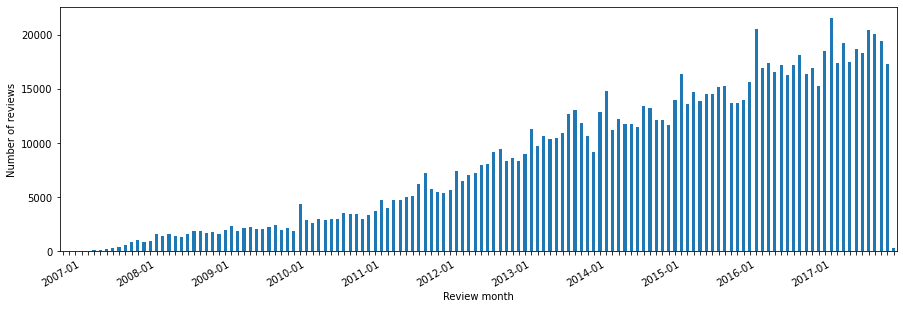

In [37]:
plt.rcParams['figure.figsize'] = [15, 5]

# group all reviews by year and month that they were published
g = review_df.groupby([review_df.date_updated.dt.year, review_df.date_updated.dt.month]).size()
# plot the number of reviews per month as a bar chart
ax = g.plot(kind='bar')
# update the ticks on the x-axis so that they remain readable...
ax.set_xticks(range(len(g)));
# ... with only a tick label for January of each year
ax.set_xticklabels(["%s-%02d" % item if item[1] == 1 else '' for item in g.index.tolist()], rotation=90);
plt.gcf().autofmt_xdate()
plt.xlabel('Review month')
plt.ylabel('Number of reviews')
plt.show()



<AxesSubplot:>

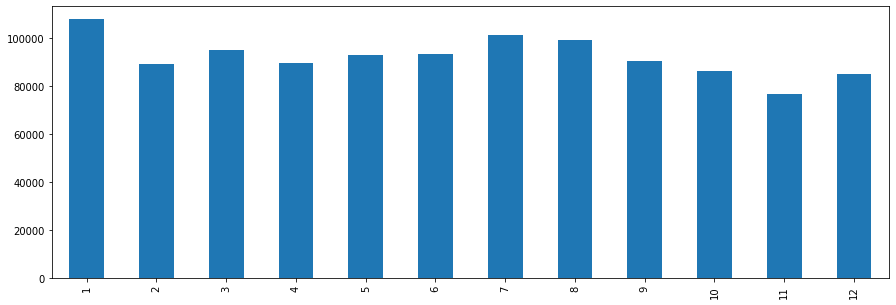

In [54]:
review_df.date_added.dt.month.value_counts().sort_index().plot(kind='bar')

January, July and August are the months with the most reviews. The January peak is probably a consequence of the Christmas holidays in the USA, where most of the reviewers in the Goodreads dataset are from. The July and August reviews are possibly due to summer holidays. 


<AxesSubplot:>

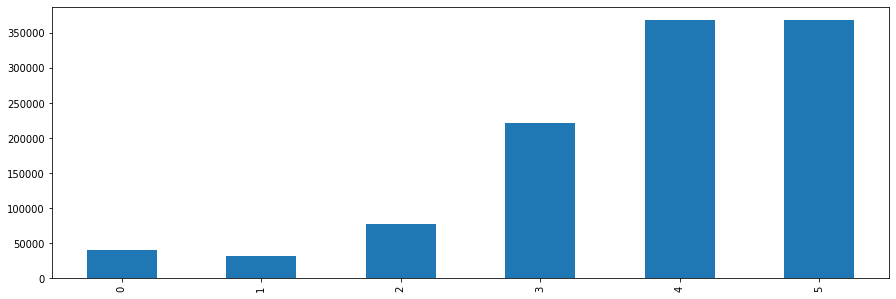

In [113]:
review_df.rating.value_counts().sort_index().plot(kind='bar')

rating,0,1,2,3,4,5
date_updated,,,,,,
2007,0.048246,0.045322,0.078034,0.220395,0.302449,0.305556
2008,0.042875,0.032043,0.082865,0.217261,0.313693,0.311263
2009,0.050650,0.035842,0.087796,0.229717,0.328518,0.267478
2010,0.050543,0.034725,0.083366,0.230796,0.333148,0.267422
2011,0.049351,0.028993,0.078967,0.220177,0.344099,0.278413
2012,0.038452,0.031554,0.074853,0.211019,0.341865,0.302257
2013,0.033521,0.028535,0.071468,0.201412,0.335722,0.329343
2014,0.029814,0.028692,0.069875,0.195384,0.331968,0.344267
2015,0.030089,0.027308,0.068839,0.193690,0.332502,0.347572


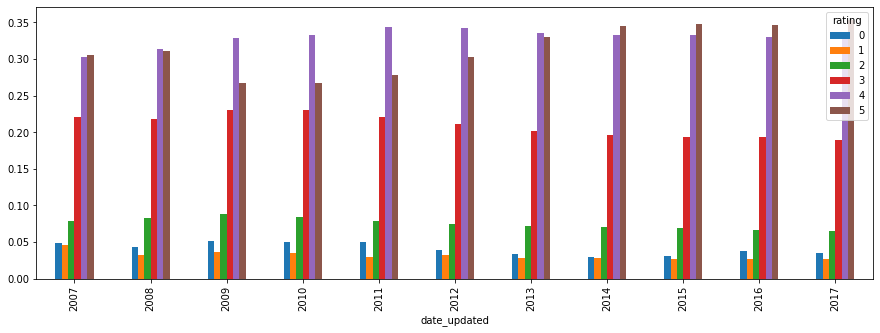

In [125]:
g = review_df.groupby([review_df.date_updated.dt.year, 'rating']).size()

u = g.unstack('date_updated')
for year in u.columns:
    u[year] = u[year] / sum(u[year])
g = u.stack()
u = g.unstack('rating')
u.plot(kind='bar')

u

Rating behaviour hasn't changed much over the years. The proportion of positive reviews (4 and 5 stars) has grown from around 60% (30% for each of 4 and 5 stars) to almost 70%, with small drops in proportion for the lower ratings.

Note that with this highly aggregated view (with 1 million reviews for over 400,000 distinct books), we cannot see how this relates to the rating behaviour for individual books, reviewers, authors or genres. For that we need to **focus** on those individual entities.

In [159]:
from scripts.text_tail_analysis import get_dataframe_review_texts

random_seed = 1205921

sample_df = review_df.sample(100, random_state=random_seed)

review_texts = [review_text for review_text in get_dataframe_review_texts(sample_df)]


In [160]:
sample_df.book_id.value_counts()

16237311    1
1140553     1
106550      1
4407        1
12471098    1
           ..
1618        1
18131118    1
10293725    1
59825       1
799232      1
Name: book_id, Length: 100, dtype: int64

All reviews are for different books. That is, in this sample there are no books with more than one review.

In [161]:
from langdetect import detect

reviews_en = [text for text in review_texts if detect(text) == 'en']
print('number of reviews:', len(review_texts))
print('number of reviews in English:', len(reviews_en))



number of reviews: 100
number of reviews in English: 91


There are 91 reviews in English. 

In [162]:
from collections import Counter
import re

tf = Counter()
for text in reviews_en:
    # split the texts on any non-word characters
    words = re.split(r'\W+', text.strip())
    # count the number of times each word occurs across the review texts
    tf.update(words)

tf.most_common(20)

[('the', 528),
 ('and', 338),
 ('I', 332),
 ('to', 271),
 ('a', 263),
 ('of', 263),
 ('in', 180),
 ('it', 168),
 ('is', 167),
 ('s', 136),
 ('that', 135),
 ('this', 133),
 ('was', 131),
 ('book', 120),
 ('with', 96),
 ('t', 89),
 ('for', 85),
 ('', 84),
 ('but', 74),
 ('The', 71)]

In [163]:
import spacy

# load the large model for English
nlp = spacy.load('en_core_web_lg')

# use nlp to parse each text and store the parsed results as a list of docs
docs = [nlp(text) for text in reviews_en]

# iterate over the docs, then over the entities in each doc and count them
tf = Counter([entity.text for doc in docs for entity in doc.ents])

tf.most_common()


[('first', 26),
 ('one', 15),
 ('two', 15),
 ('Alice', 14),
 ('three', 10),
 ('Anne', 9),
 ('Baratte', 8),
 ('Louisa', 8),
 ('Iran', 6),
 ('second', 5),
 ('Mary Anne', 5),
 ("Mary Anne's", 5),
 ('5', 4),
 ('English', 4),
 ('third', 4),
 ('Asher', 4),
 ('Wiebe', 4),
 ('One', 4),
 ('these days', 4),
 ('Jean-Baptiste Baratte', 4),
 ('Les Innocents', 4),
 ('Wonderland', 4),
 ('Jamie', 4),
 ('Godwin', 4),
 ('Caleb', 4),
 ('Edward', 4),
 ('Marjane', 4),
 ('Dawn', 4),
 ('BSC', 4),
 ('half', 4),
 ('today', 3),
 ('Beck', 3),
 ('Anne Merchant', 3),
 ('Cania Christy', 3),
 ('Gaiman', 3),
 ('f**king', 3),
 ('iLove', 3),
 ('Simon', 3),
 ('John Grey', 3),
 ('John', 3),
 ('Bella', 3),
 ('32', 2),
 ('Scout', 2),
 ('Atticus', 2),
 ('Alabama', 2),
 ('fourth', 2),
 ('eight', 2),
 ('nine', 2),
 ('Katarina', 2),
 ('Allie', 2),
 ('COOPER', 2),
 ('Chelcie', 2),
 ('days', 2),
 ("Cania Christy's", 2),
 ('A Little Life', 2),
 ('Simenon', 2),
 ('12,000', 2),
 ('Yunior', 2),
 ('Diaz', 2),
 ('American', 2),
 ('Sam

With just 100 reviews, all for different books, it is perhaps surprising that the most frequent entities are very specific names that appear many times ('Jessamin', 'Finn', 'Albion', 'Rakhi', 'Black Snow', 'Bulgakov').

But this becomes more understandable when we take into account that some reviews are long and repeat the same names of authors and characters multiple times. We can compensate for this by looking at the **document frequency**, e.g. the number of documents (each review is a document) in which a term occurs. 

In [164]:
df_ent = Counter([entity for doc in docs for entity in set([ent.text for ent in doc.ents])])

df_ent.most_common()

[('first', 17),
 ('two', 12),
 ('one', 11),
 ('three', 8),
 ('second', 5),
 ('5', 4),
 ('third', 4),
 ('One', 4),
 ('these days', 4),
 ('today', 3),
 ('English', 3),
 ('fourth', 2),
 ('American', 2),
 ('3', 2),
 ('Louisa', 2),
 ('NetGalley', 2),
 ('America', 2),
 ('five', 2),
 ('half', 2),
 ('Lea Rachel', 1),
 ('56', 1),
 ('32', 1),
 ("William Shakespeare's", 1),
 ('31', 1),
 ('34', 1),
 ('58', 1),
 ('ages 9-14', 1),
 ('7th', 1),
 ('Jem', 1),
 ('a couple of weeks', 1),
 ('Alabama', 1),
 ('Scout', 1),
 ('Atticus', 1),
 ('eight', 1),
 ('Thalia', 1),
 ('The Glass Princess', 1),
 ('Sixth', 1),
 ('Justin Richards', 1),
 ('Katarina', 1),
 ('Calliope', 1),
 ('The Brain of Socrates', 1),
 ('the Fourth Doctor and Leela', 1),
 ('2003', 1),
 ('Gareth Roberts', 1),
 ('Robert Shearman', 1),
 ('Jac Rayner', 1),
 ('Clio', 1),
 ('Steve Lyons', 1),
 ('Teach Yourself Ballroom Dancing', 1),
 ('nine', 1),
 ('Finish Short Trips', 1),
 ('Terpsichore', 1),
 ('Net Galley', 1),
 ('Crooked Lane Books', 1),
 ('A

The names that remain are mostly more common terms in the book review domain ('Goodreads', 'Amazon') and more common names of authors or characters ('Elizabeth'). But also the highest frequencies of such names is much lower than the *term frequency*.

The high *term frequency* of specific names **is a consequence of the scale at which we are looking** at the random sample of reviews. With only 100 reviews, the influence of a single long review can and probably will be significant. As the number of randomly sampled reviews grows, the proportional contribution of individual reviews goes down. As we saw with the [content analysis of reviews for popular books](./Goodreads-Content-Analysis-Popular-Books.ipynb), **zooming out has the effect of bringing the commonalities across reviews into focus**. 

If all reviews are of the same book (that is, the *focus* is on the book, the commonalities will probably contain names of author and characters and other plot-related aspects. If all reviews are of books in a specific genre (e.g. *romance* or *mystery, crime and thriller*, the commonalities will probably include genre tropes as well as generic aspects of books like narrative (story, plot, characters), and writing style (phrasing, pace, tone and mood). If all reviews are of different books across a wide range of genres, the influence of individual books or and genres is drowned out in the heterogeneity of the *selection*, and the *focus* will shift to what is common across book reviews in general, which are aspects of writing style and quality.

In [187]:
from collections import Counter
import re

from scripts.text_tail_analysis import get_dataframe_review_texts
from langdetect.lang_detect_exception import LangDetectException

def detect_lang(text):
    try:
        return detect(text)
    except LangDetectException:
        return None

random_seed = 1205921

sample_df = review_df.sample(10000, random_state=random_seed)

review_texts = [review_text for review_text in get_dataframe_review_texts(sample_df)]
reviews_en = [text for text in review_texts if len(text) > 0 and detect_lang(text) == 'en']
print('number of reviews in sample:', len(review_texts))
print('number of English reviews in sample:', len(reviews_en))
print('number of reviewed books in sample:', sample_df.book_id.nunique())

tf = Counter()
for text in reviews_en:
    # split the texts on any non-word characters
    words = re.split(r'\W+', text.strip())
    # count the number of times each word occurs across the review texts
    tf.update(words)

tf.most_common(20)

number of reviews in sample: 10000
number of English reviews in sample: 8790
number of reviewed books in sample: 8866


[('the', 50859),
 ('and', 35437),
 ('I', 31695),
 ('to', 29932),
 ('a', 29613),
 ('of', 27066),
 ('is', 16944),
 ('in', 16481),
 ('it', 15034),
 ('that', 14894),
 ('was', 12994),
 ('this', 12178),
 ('s', 11826),
 ('book', 11401),
 ('for', 9643),
 ('with', 8883),
 ('', 8264),
 ('t', 8251),
 ('her', 8099),
 ('but', 7980)]

With 10,000 reviews, the top 20 terms start to look more like a common stopword list, with just the domain stopword 'book' in there as well. If we would sample ever more reviews, the list of most frequent words will get ever close to existing stopword lists. 

Note that these reviews are for 8,866 different books, so the vast majority of books will have only a single review. In other words, to the extent that there is overlap between reviews, it mostly comes from commonalities across a large set of randomly selected books. 

In [265]:
from scripts.text_tail_analysis import write_docs_to_bin, read_docs_from_bin
#docs = [nlp(text) for text in reviews_en]
nlp_docs_file = f'../data/review_spacy_docs.random_1M.sample-10000.seed-{random_seed}.docbin'

#write_docs_to_bin(docs, nlp_docs_file)

docs = read_docs_from_bin(nlp_docs_file, nlp)

# iterate over the docs, then over the entities in each doc and count them
tf = Counter([entity.text for doc in docs for entity in doc.ents])

print('Total number of entities in the sample:', sum(tf.values()))
tf.most_common(50)


Total number of entities in the sample: 54675


[('first', 1853),
 ('one', 1561),
 ('two', 1156),
 ('second', 486),
 ('One', 339),
 ('three', 330),
 ('5', 299),
 ('3', 246),
 ('2', 227),
 ('4', 207),
 ('third', 172),
 ('3.5', 156),
 ('four', 154),
 ('Jack', 137),
 ('Sam', 135),
 ('five', 135),
 ('today', 135),
 ('half', 130),
 ('First', 129),
 ('American', 124),
 ('1', 119),
 ('Alex', 107),
 ('4.5', 105),
 ('Christmas', 101),
 ('English', 100),
 ('Kate', 87),
 ('America', 86),
 ('years', 84),
 ('French', 81),
 ('Anna', 80),
 ('Emma', 79),
 ('London', 77),
 ('POV', 73),
 ('ARC', 72),
 ('Rachel', 70),
 ('Christian', 69),
 ('Grace', 68),
 ('Ben', 67),
 ('Max', 66),
 ('Jake', 64),
 ('NetGalley', 62),
 ('Nick', 60),
 ('Harry', 60),
 ('Two', 58),
 ('Tom', 58),
 ('British', 57),
 ('Elizabeth', 55),
 ('Harry Potter', 55),
 ('England', 55),
 ('Jamie', 54)]

The most frequent entities now have very generic entities, including numbers, common names of persons and geographic locations and very popular books ('Harry Potter'). But note that even the common person names 'Jack' and 'Sam' occur only 137 and 135 times respectively in 10,000 reviews and 54,675 entities. 

If we shift from *term frequency* to *document frequency*, the person names even further:

In [175]:
df_ent = Counter([entity for doc in docs for entity in set([ent.text for ent in doc.ents])])

df_ent.most_common(50)

[('first', 1382),
 ('one', 1192),
 ('two', 867),
 ('second', 429),
 ('One', 299),
 ('three', 277),
 ('5', 242),
 ('2', 205),
 ('3', 203),
 ('4', 180),
 ('third', 151),
 ('3.5', 147),
 ('four', 128),
 ('First', 124),
 ('today', 120),
 ('five', 118),
 ('half', 115),
 ('1', 108),
 ('American', 94),
 ('4.5', 94),
 ('English', 85),
 ('years', 81),
 ('ARC', 69),
 ('London', 67),
 ('POV', 65),
 ('Jack', 63),
 ('America', 61),
 ('Christmas', 59),
 ('NetGalley', 58),
 ('French', 58),
 ('Two', 53),
 ('the day', 52),
 ('Christian', 49),
 ('one day', 48),
 ('England', 48),
 ('British', 47),
 ('Sam', 46),
 ('2.5', 44),
 ('fourth', 44),
 ('Netgalley', 43),
 ('Harry Potter', 43),
 ('Goodreads', 42),
 ('HEA', 42),
 ('the years', 40),
 ('summer', 39),
 ('this year', 36),
 ('New York', 36),
 ('Three', 36),
 ('Alex', 36),
 ('Emma', 35)]

In [179]:
tf_word = Counter([token.text for doc in docs for token in doc if not token.is_stop and not token.is_punct])

print('Number of words:', sum(tf_word.values()))
print('Number of distinct words:', len(tf_word.keys()))


Number of words: 514791
Number of distinct words: 44024


In [180]:
sizes = [10, 20, 100, 200]
for size in sizes:
    sum_top = sum([freq for term, freq in tf_word.most_common(size)])
    print(f'Sum frequency of top {size} terms: {sum_top} (fraction: {sum_top / sum(tf_word.values()): >.2f})')


Sum frequency of top 10 terms: 55996 (fraction: 0.11)
Sum frequency of top 20 terms: 73309 (fraction: 0.14)
Sum frequency of top 100 terms: 137086 (fraction: 0.27)
Sum frequency of top 200 terms: 175572 (fraction: 0.34)


The proportion of the top terms is lower in a heterogeneous set of reviews than in a set of reviews focused in a single book. In the [content analysis of reviews for popular books](./Goodreads-Content-Analysis-Popular-Books.ipynb) we found 27,632 distinct words, versus 44,024 in these more heterogeneous reviews. Furthermore, top 10 terms represent 16% of all occurring words in reviews for a single popular book, while in this selection it is 11%. For the top 200 terms, the numbers are 54% and 34% respectively. In other words, the wider focus of the random selection also leads to a larger vocabulary that is less skewed. (Less skewed because the total numbers of words is not so different. The 10,000 single-book reviews contain 487,298 words, while the 10,000 randomly sampled reviews contain 514,791 words. 

### Long Tails and Classification



In [184]:
from collections import defaultdict
from scripts.text_tail_analysis import show_pos_tail_distribution

tf_lemma_pos = Counter([(token.lemma_, token.pos_) for doc in docs for token in doc if not token.is_stop and not token.is_punct])

show_pos_tail_distribution(tf_lemma_pos)

Word form	All TF (frac)	TF <= 5 (frac)	TF = 1 (frac)
------------------------------------------------------------
ADJ       	   78737  0.15	  6784  0.13	  2017  0.11
VERB      	  123434  0.24	  4939   0.1	  1384  0.08
NOUN      	  197692  0.38	 13313  0.26	  4213  0.23
PROPN     	   61135  0.12	 22795  0.44	  8893  0.49
ADV       	   23982  0.05	  1621  0.03	   573  0.03
SPACE     	   16429  0.03	     0   0.0	     0   0.0
INTJ      	    2703  0.01	   395  0.01	   172  0.01
NUM       	    4878  0.01	   856  0.02	   397  0.02
ADP       	     543  0.00	    85   0.0	    44   0.0
SCONJ     	    3220  0.01	     5   0.0	     0   0.0
PRON      	     197  0.00	    45   0.0	    32   0.0
X         	     957  0.00	   539  0.01	   377  0.02
CCONJ     	     205  0.00	    16   0.0	     9   0.0
PUNCT     	     329  0.00	   195   0.0	   132  0.01
PART      	     170  0.00	     4   0.0	     4   0.0
DET       	      99  0.00	    42   0.0	    27   0.0
SYM       	      81  0.00	     6   0.0	     3   0.0


We see now that in the tail, almost half of all single-occurrence terms are proper nouns. With 8,866 different books being reviewed, there are probably many different names from characters, places, events and other entities. It is also possible that some non-English reviews got misclassified as English and Spacy does not recognize their words as English words so classifies many or most of them as proper nouns. 

We should inspect the tail to see what is going on.

In [192]:
from scripts.text_tail_analysis import show_tail_lemmas

show_tail_lemmas(tf_lemma_pos, tf_threshold=1, pos='PROPN', num_lemmas=100)


night           Amis            Limbo           thy             eARCs           
Encyclopaedists Kovite          Bookworms       Balicki         Balicki(father  
Switzerland     .This           luke            Sidman          Summerstoke     
Merfield        Marsh           Isabell         Garnett         Semple          
Timby           LaMar           Poptropica      Bennig          Seymour         
Shubin          Thrillogy       Anansi          kakamochi       Punahou         
Lea             AngelWay        Rina            Arlington       Darkwing        
Blane           Mickelson       Matterhorn      R.A.            Mielikki        
Lah             hackeysack      Beijing         atmospherey     Hovercars       
Agricorps       Bandomreer      Bandomeer       Thibault        connected       
Shape           WW              eDiets          Heigl           Taboo           
Berris          Norris          coq             au              vin             
Timeless        Scarbrough  

There are indeed many names of places, organizations and persons or fictional characters. But there are also a lot of non-English terms in here, with the last 20 or so being probably Italian. As said, it is possible that some reviews were misclassified in terms of language, but another possibility is that reviews contain quotes in different languages. 

Let's look at one of the reviews with these Italian terms, e.g. the one containing the word 'dettaglio':

In [263]:
for doc in docs:
    for token in doc:
        if token.text == 'dettaglio':
            print(doc)

Scroll down for the English version.   La lotta contro il mostro   Avevo da un po' di tempo questo libro, non so neppure come me lo fossi procurato, e ho iniziato a leggerlo perche incuriosita dalla descrizione.   In realta, e direi anche per fortuna, la storia narrata ha ben poco a che vedere con la quarta di copertina, che descrive solo un dettaglio di una delle storie che si intrecciano in questo bellissimo romanzo, ma soprattutto non fa il minimo accenno all'argomento principale che lo anima: l'alcolismo.   Un medico, un operaio, un sacerdote, la giovane rampolla di una famiglia facoltosa, persone diverse che si incontrano all'interno della storia proprio a causa della loro dipendenza dall'alcol.   L'autore entra nella mente dell'alcolista e riesce a mostrare al lettore quale filo di pensieri spinge il primo a tornare bere, anche dopo essere stato malissimo e aver giurato se stesso che avrebbe smesso, anche se questo significa trascurare le persone che ama e che l'amano, anche se p

We see another reason for the occurrence of non-English terms: reviews with versions of the text in multiple languages. As is typical with user-generated content on the web, at large scale, the variation in contributions is enormous [1]. With so many different people contributing, each in their own way, variation grows as the number of contributions grow.

[1] X. Ochoa, E. Duval, [Quantitative analysis of user-generated content on the web](http://vima01220.ethz.ch/WWW/www2008/ws-workshop/WebEvolve2008-03.pdf), 2008.


## Reviews of Prolific Reviewers

Let's look at the contributing reviewers. We expect most reviewers to contribute only a single review, but no doubt there are a small number of highly prolific reviewers contributing hundreds of reviews. 

In [195]:
review_df.user_id.value_counts()

a2d6dd1685e5aa0a72c9410f8f55e056    1474
459a6c4decf925aedd08e45045c0d8c6     716
4922591667fd3e8adc0c5e3d42cf557a     710
843a44e2499ba9362b47a089b0b0ce75     666
dd9785b14664103617304996541ed77a     610
                                    ... 
1bf135f904e8a5f40155668044764afb       1
b0fdb686313d58bd622a0852aad2c4a2       1
a4e803cd1c6677c75abd23ad70740a07       1
0e081be86e69d2a3ecc95a655d31cc5f       1
785e5b3ab68616ed228e02dd74363824       1
Name: user_id, Length: 205264, dtype: int64

In this random sample of 1 million reviews (which is only a fraction of the 15 million reviews that were crawled, which is only a fraction of the over 90 million reviews on Goodreads [2]), there is a reviewer with staggering 1474 reviews.

[2] [Goodreads - About us](https://www.goodreads.com/about/us) (Accessed 2020-08-04).

In [196]:
reviewer = 'a2d6dd1685e5aa0a72c9410f8f55e056'

reviewer_df = review_df[review_df.user_id == reviewer]
reviewer_df.rating.value_counts().sort_index()

0    1474
Name: rating, dtype: int64

This reviewer provides no ratings. Let's look at the temporal distribution of the reviews.

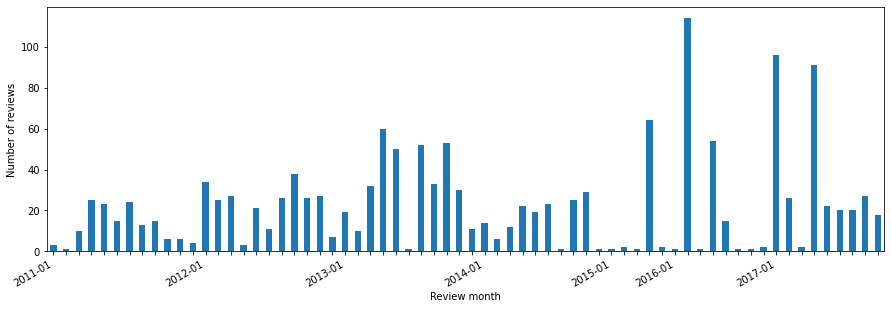

In [204]:
#reviewer_df.date_updated.dt.year.value_counts().sort_index().plot(kind='bar')

# group all reviews by year and month that they were published
g = reviewer_df.groupby([reviewer_df.date_updated.dt.year, reviewer_df.date_updated.dt.month]).size()
# plot the number of reviews per month as a bar chart
ax = g.plot(kind='bar')
# update the ticks on the x-axis so that they remain readable...
ax.set_xticks(range(len(g)));
# ... with only a tick label for January of each year
ax.set_xticklabels(["%s-%02d" % item if item[1] == 1 else '' for item in g.index.tolist()], rotation=90);
plt.gcf().autofmt_xdate()
plt.xlabel('Review month')
plt.ylabel('Number of reviews')
plt.show()

This reviewer has been contributing reviews since 2011, with many months where they contributed more than 20 reviews and a peak in 2016 with over 100 reviews.

Let's look at the length of these reviews.

<AxesSubplot:>

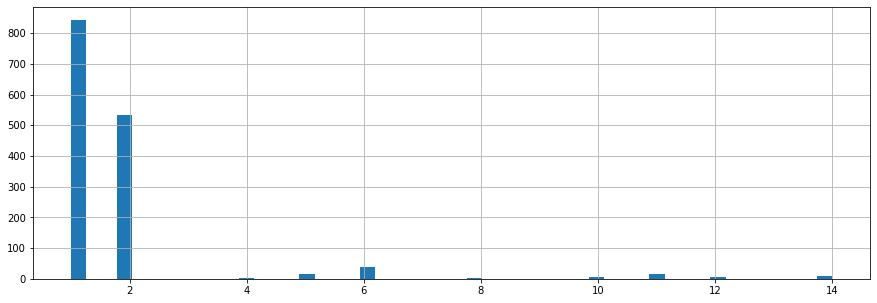

In [213]:
reviewer_df.review_length.hist(bins=50)



Almost all reviews are only one or two characters in length. What is going on here?

In [215]:
reviewer_df[reviewer_df.review_length == 1].review_text.value_counts()

O    305
A    301
E    236
F      1
Name: review_text, dtype: int64

In [216]:
reviewer_df[reviewer_df.review_length == 2].review_text.value_counts()

SM    535
Name: review_text, dtype: int64

These look like idiosyncratic code that make sense to reviewer, but not necessarily to many others. It might be that these reflect ratings. **This demonstrates again the enormous variation that is typically found in user-generated content.**

Let's look for prolific reviewers who write longer reviews:

In [234]:
review_df[review_df.review_length > 100].user_id.value_counts()

843a44e2499ba9362b47a089b0b0ce75    660
9003d274774f4c47e62f77600b08ac1d    520
dd9785b14664103617304996541ed77a    486
b7772313835ce6257a3fbe7ad2649a29    449
8bb031b637de69eba020a8a466d1110b    377
                                   ... 
725bd65f3662a4c5325ed47617f870fe      1
862ce18aeb9e74094084ae2480d1f464      1
0dc500dd128b0e21ceb78586149e24a2      1
bfecfc020966f12c52edf574d094509a      1
571381fc614f55e6dc0f50868a47fb38      1
Name: user_id, Length: 172242, dtype: int64

In [251]:
reviewer = '843a44e2499ba9362b47a089b0b0ce75'

reviewer_df = review_df[review_df.user_id == reviewer]

print('reviewer number of reviews:', len(reviewer_df))
print('reviewer ratings:')
reviewer_df.rating.value_counts().sort_index()

reviewer number of reviews: 666
reviewer ratings:


1     62
2    132
3    344
4    114
5     14
Name: rating, dtype: int64

<AxesSubplot:>

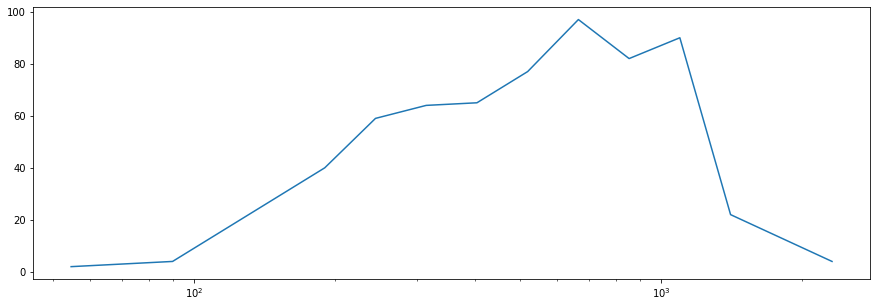

In [237]:
reviewer_df.length_bin.value_counts().sort_index().plot(logx=True)

In [238]:
reviewer_texts = [review_text for review_text in get_dataframe_review_texts(reviewer_df)]
reviewer_texts_en = [text for text in reviewer_texts if len(text) > 0 and detect_lang(text) == 'en']

reviewer_docs = [nlp(text) for text in reviewer_texts_en]


In [253]:
tf_word = Counter([token.text for doc in reviewer_docs for token in doc if not token.is_stop and not token.is_punct])


print('Number of total words (tokens):', sum(tf_word.values()))
print('Number of distinct words (types):', len(tf_word.keys()))

tf_word.most_common(20)

Number of total words (tokens): 34719
Number of distinct words (types): 5062


[('  ', 1035),
 ('book', 753),
 ('like', 562),
 ('things', 455),
 ('story', 402),
 ('liked', 388),
 ('loved', 336),
 ('think', 255),
 ('way', 242),
 ('end', 238),
 ('time', 237),
 ('great', 214),
 ('sure', 207),
 ('know', 204),
 ('found', 196),
 ('going', 195),
 ('people', 188),
 ('bad', 182),
 ('series', 182),
 ('interesting', 179)]

In [254]:
tf_ent = Counter([ent.text for doc in reviewer_docs for ent in doc.ents])

print('Number of total entities (tokens):', sum(tf_ent.values()))
print('Number of distinct entities (types):', len(tf_ent.keys()))


tf_ent.most_common()

Number of total entities (tokens): 4310
Number of distinct entities (types): 1155


[('first', 139),
 ('one', 118),
 ('Warren', 48),
 ('2', 46),
 ('Kyle', 40),
 ('two', 35),
 ('Rick', 34),
 ('Hardin', 32),
 ('Alex', 30),
 ('HEA', 26),
 ('Alice', 26),
 ('Lucas', 24),
 ('Sam', 23),
 ('half', 23),
 ('Kelley Armstrong', 23),
 ('Jill', 22),
 ('Ian', 21),
 ('Lily', 21),
 ('Claire', 21),
 ('Marr', 20),
 ('Liam', 19),
 ('Nick', 19),
 ('Anna', 19),
 ('Sara', 19),
 ('Helen', 19),
 ('Gabe', 19),
 ('Sookie', 19),
 ('3', 18),
 ('Lucy', 18),
 ('Vaughn', 17),
 ('second', 16),
 ('Cole', 16),
 ('Cam', 16),
 ('Charlaine Harris', 16),
 ('Carrie Vaughn', 16),
 ('MLN Hanover', 16),
 ('Patricia Briggs', 16),
 ('Harris', 16),
 ('Brigg', 16),
 ('Ben', 15),
 ('Logan', 15),
 ('Shane', 15),
 ('Jody', 15),
 ('Hannah', 14),
 ('Rafe', 14),
 ('Jack', 14),
 ('Max', 14),
 ('Mike', 14),
 ('Seth', 14),
 ('Eve', 13),
 ('Rory', 13),
 ('Emma', 13),
 ('Sean', 13),
 ('Eric', 13),
 ('Val', 13),
 ('Damien', 13),
 ('Maggie', 12),
 ('Molly', 12),
 ('Matt', 12),
 ('Becky', 12),
 ('George', 12),
 ('Amy', 11),
 ('

The entity list contains a large number of first person names, and many of them with a relatively high frequency. In the 34,719 words of all this reviewer's reviews, there are 4,310 named entities (some with multiple words). So it seems this reviewers has a tendency to name the characters in their review.

In [261]:
from collections import defaultdict
from scripts.text_tail_analysis import show_pos_tail_distribution

tf_lemma_pos = Counter([(token.lemma_, token.pos_) for doc in reviewer_docs for token in doc if not token.is_stop and not token.is_punct])

show_pos_tail_distribution(tf_lemma_pos)

Word form	All TF (frac)	TF <= 5 (frac)	TF = 1 (frac)
------------------------------------------------------------
ADJ       	    4835  0.14	   944  0.15	   345  0.17
NOUN      	   11723  0.34	  2337  0.36	   791  0.38
VERB      	   10984  0.32	  1110  0.17	   361  0.18
NUM       	     224  0.01	    48  0.01	    16  0.01
PROPN     	    4258  0.12	  1774  0.27	   450  0.22
SPACE     	    1035  0.03	     0   0.0	     0   0.0
ADV       	    1150  0.03	   225  0.03	    69  0.03
SCONJ     	     353  0.01	     1   0.0	     1   0.0
INTJ      	     102  0.00	    29   0.0	    12  0.01
PRON      	       8  0.00	     2   0.0	     2   0.0
DET       	      19  0.00	     1   0.0	     1   0.0
ADP       	      24  0.00	     9   0.0	     3   0.0
CCONJ     	       2  0.00	     2   0.0	     2   0.0
X         	       2  0.00	     2   0.0	     2   0.0


In [259]:
from scripts.text_tail_analysis import show_tail_lemmas

show_tail_lemmas(tf_lemma_pos, tf_threshold=1, pos='NOUN', num_lemmas=100)



jacket          Griffin         Trixa           loud            request         
shelf           kooky           march           beat            drummer         
normal          laughter        enjoyment       location        blow            
ramification    push            shove           dive            translate       
increment       Luce            bud             thug            unexplained     
Imogene         brainy          nascar          prevail         unthinkable     
forefront       straighten      tantrum         school          confide         
sarcasm         phantom         innuendo        storm           inhabitant      
racism          soccer          coward          childlike       acceptation     
better          odd             uncomfortablenessjunior          attorney        
reclaim         Jilly           loner           absolute        capable         
chronicle       leak            dialogue        awwww           stake           
claim           together   

In [249]:
for genre in genres:
    print(f'{genre: <40}{reviewer_df[reviewer_df[genre] == 1][genre].count(): >5}')

children                                   27
comics, graphic                            11
fantasy, paranormal                       363
fiction                                   598
history, historical fiction, biography     92
mystery, thriller, crime                  339
non-fiction                                38
poetry                                      0
romance                                   566
young-adult                               171


Most of the reviewed books are *romance* (566 out of 666), with an overlap with *mystery, thriller, crime* and *fantasy, paranormal*.

In [250]:
reviewer_df.author_name.value_counts()

Paige Tyler              6
Suzanne Brockmann        6
Kelley Armstrong         6
Shayla Black             5
Sherryl Woods            5
                        ..
Fine Cooking Magazine    1
Nathan Ballingrud        1
Jennifer Graham          1
Tracey Garvis-Graves     1
Raine Thomas             1
Name: author_name, Length: 469, dtype: int64